In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Make plots pretty, deactivate "font.serif": ["Linux Libertine"] if font not installed!!
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler(color=["black"] +  plt.rcParams['axes.prop_cycle'].by_key()['color']),
    "font.family": "serif",             # Serif fonts (e.g., Times-like)
    "font.serif": ["Linux Libertine"],  # Same font as in LaTeX, must be installed!
    "font.size": 12,                    # Base font size
    "mathtext.fontset": "cm",           # Math Font to match a bit better
    "legend.fontsize": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
    "figure.dpi": 300,                  # High resolution
    "savefig.dpi": 300,
    "axes.linewidth": 0.8,              # Thin axis lines
    "xtick.direction": "in",            # Ticks pointing inward
    "ytick.direction": "in",
    "xtick.top": True,                  # Ticks on all sides
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "grid.linewidth": 0.4
})

default_fsize = (5,3.5)

## (i) - (ii)
Loading the data:

In [2]:
def load_dat(filename):
    data_path = os.path.join("data", filename)
    return pd.read_csv(data_path, 
                       delimiter=r'\s+',
                       header=None,
                       usecols=[2,5,7],
                       names=['t_lb','V_m/V_v','MAR']
                       )

masses = [10.0,10.5,11.0,11.5,12.0,12.5,13.5]
data = {}
for i, fname in enumerate(os.listdir('data')):
    path = os.path.join('data', fname)
    data[masses[i]] = load_dat(fname)

data[10].head()

,t_lb,V_m/V_v,MAR
0,0.0015,0.12801,0.26892
1,0.1269,0.12806,0.18649
2,0.2519,0.12809,0.19827
3,0.3763,0.12812,0.20586
4,0.5002,0.12814,0.21330


Converting the time to cosmic

In [3]:
for mass, df in data.items():
    df['t_c'] = 13.8 - df['t_lb'] 

data[10].head()

,t_lb,V_m/V_v,MAR,t_c
0,0.0015,0.12801,0.26892,13.7985
1,0.1269,0.12806,0.18649,13.6731
2,0.2519,0.12809,0.19827,13.5481
3,0.3763,0.12812,0.20586,13.4237
4,0.5002,0.12814,0.21330,13.2998


Now the interpolation plot:

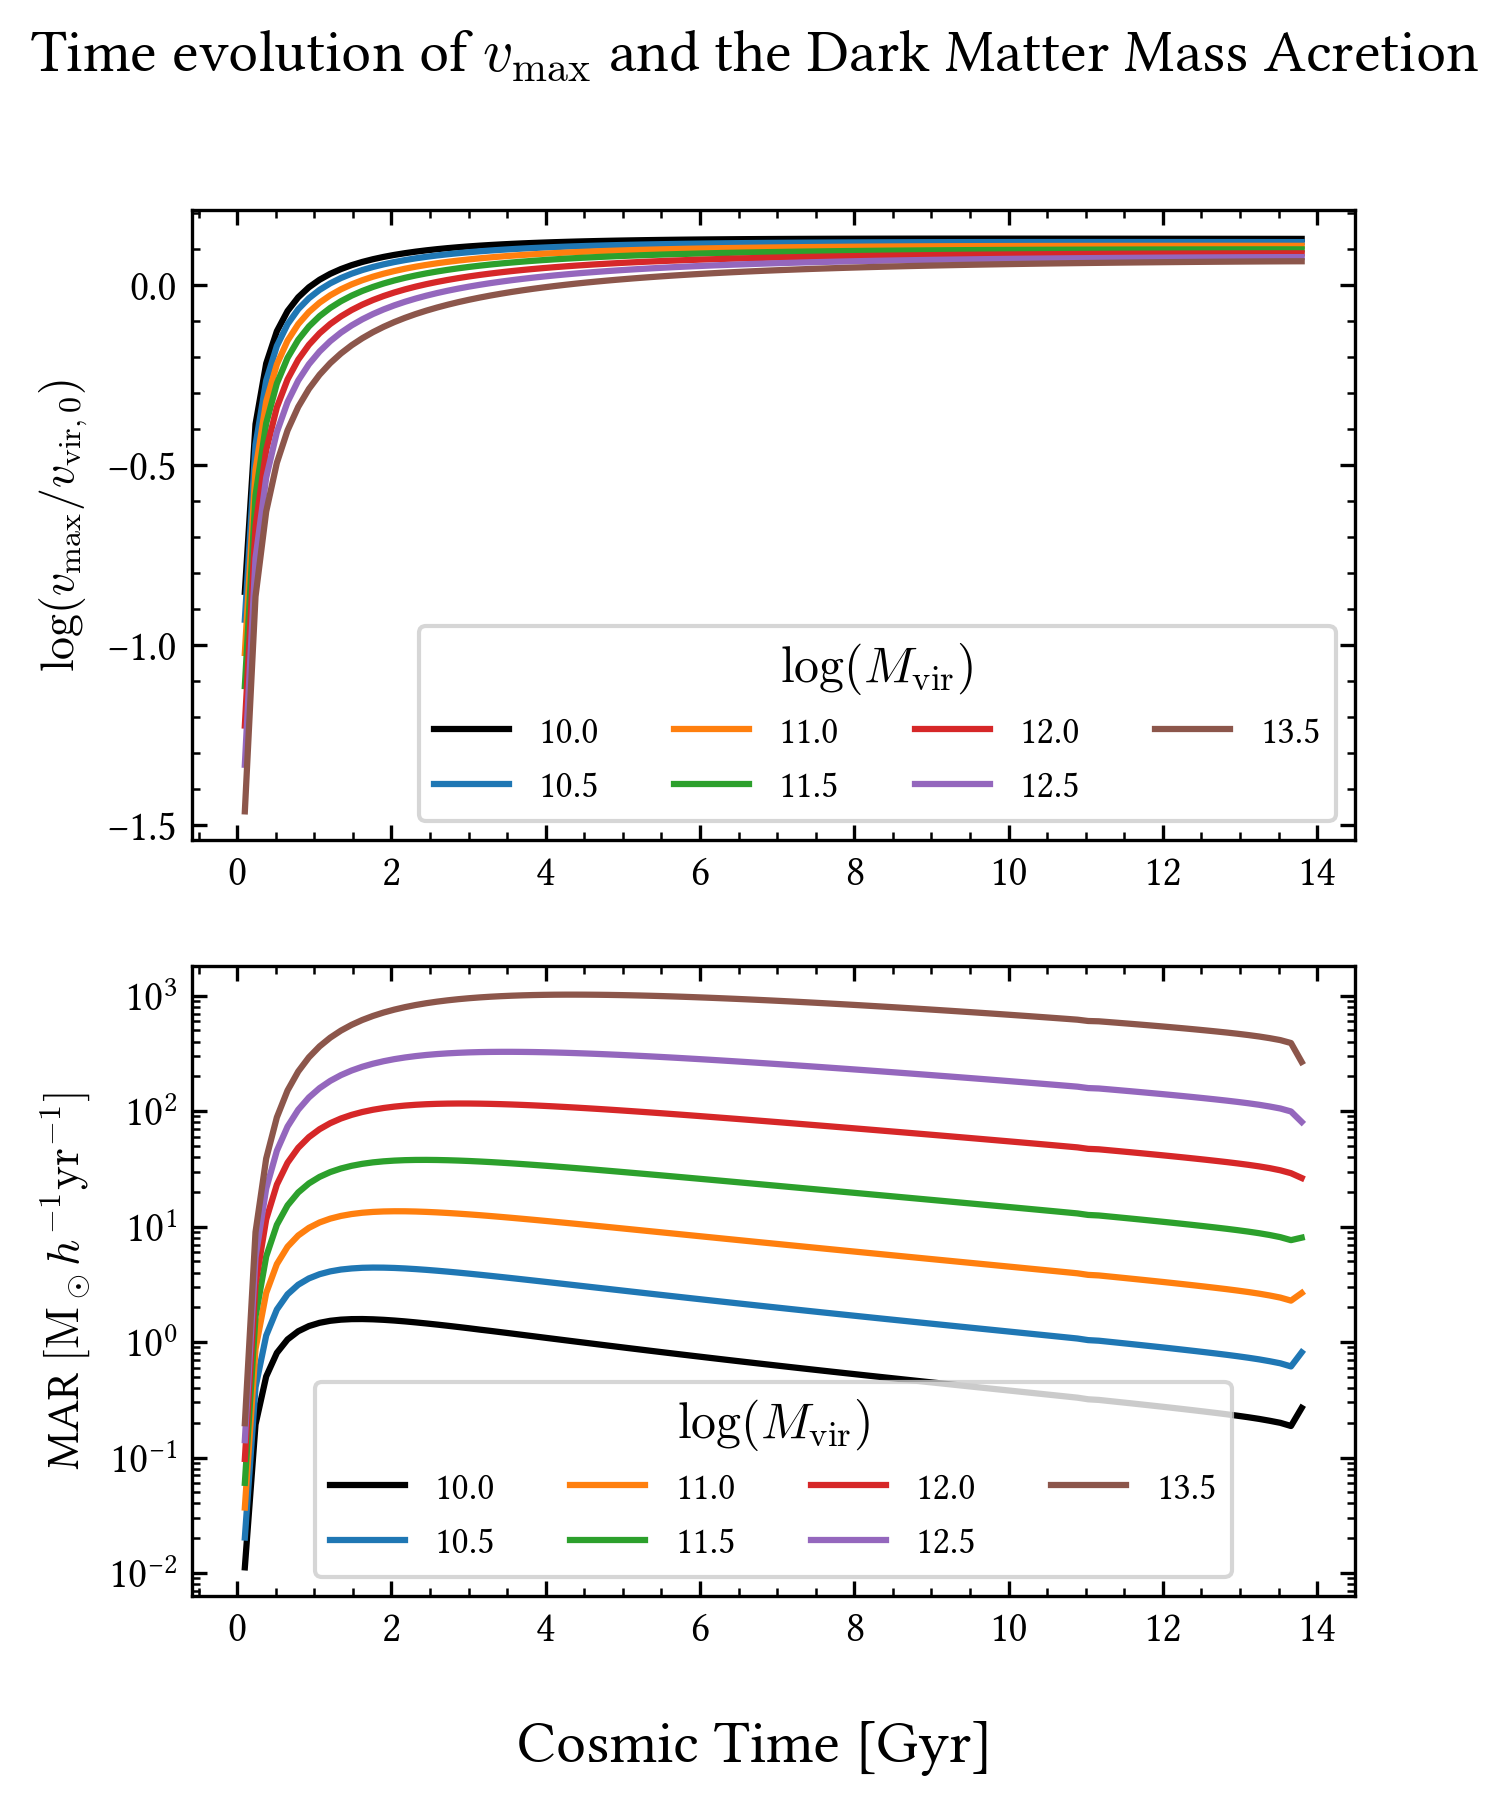

In [25]:
t_space = np.linspace(0.1,13.8,100)

fig, ax = plt.subplots(2,sharex=True,figsize = (5,6))
fig.suptitle(r"Time evolution of $v_{\text{max}}$ and the Dark Matter Mass Acretion")
ax[0].set_ylabel(r'$\log(v_{\text{max}}/v_{\text{vir},0})$')
ax[1].set_ylabel(r'MAR $[\text{M}_\odot h^{-1} \text{yr}^{-1}]$')
fig.supxlabel('Cosmic Time [Gyr]')

for mass, df in data.items():
    y_v = np.interp(t_space,df['t_c'][::-1],df['V_m/V_v'][::-1])
    y_MAR = np.interp(t_space,df['t_c'][::-1],df['MAR'][::-1])
    ax[0].plot(t_space,y_v,label=f'{mass}')
    ax[1].plot(t_space,y_MAR,label=f'{mass}')

ax[0].tick_params(labelbottom=True)
ax[0].legend(title=r'$\log(M_{\text{vir}})$',ncol=4)
ax[1].legend(title=r'$\log(M_{\text{vir}})$',ncol=4)
ax[1].set_yscale('log')

## (iii - v)
We will use eulers methods to solve the different time evolutions. Our rough sketch:

```python
# Initialize
M_dm, M_g, M_star, SFR, dM_g = zeroes
dM_dm = interp(data) 

# Start values
SFR[0] = A * M_g
dM_g[0] = gamma(0) * f_b * dM_dm[0] - (1-R) * SFR # Assuming here that gas outflow = 0

for i,t enumerate t_space:
    M_dm[i+1] = M_dm[0] + dM_dm[0]
    M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt
    M_g[i+1] = M_g[i] + dM_gas * dt

    SFR[i+1] = A * M_g[i+1]
    dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1]

```
    For initial values at $t_c = 0$ we will assume 0 for each mass (DM, gas and stellar).

In [5]:
def gamma(M_dm):
    M_crit = 6e11 # Critical Mass [Solar Masses]
    if M_dm > M_crit:
        return 0.3
    else:
        return 1

def mass_evolution(M_vir, df, f_b=0.18, stellar_frac=0.09, n_steps=100):
    ''' 
    Models the backwards evolution of the different masses

    INPUT
    -----
    M_vir : (float)
        Log_10 of the virial mass of the galaxy
    df : (pd.DataFrame)
        Dataframe with columns ['t_c','MAR']
    f_b : (float)
        Fraction of baryonic matter
    stellar_frac : (float)
        Fraction of stelar mass from total matter
    n_steps : int
        Number of time steps for the evolution

    OUTPUT
    -----
    t_reverse, M_dm, M_g, M_star, SFR : np.ndarray
        the results

    '''

    R = 0.4
    A = 2e-10

    # Initialize
    t_cosmic = np.linspace(0.1,13.8,n_steps) # equidistant cosmic time in Gyr
    dt = 13.8 / n_steps * 1e9 # in yr

    dM_dm = np.interp(t_cosmic,df['t_c'][::-1],df['MAR'][::-1]) # Not sure if this h is correct ???

    M_dm, M_g, M_star, SFR, dM_g = np.zeros((5,n_steps))

    # Initial Values at t=t_0
    
    # M_dm[0], M_g[0], M_star[0] = get_initial_mass(M_vir, df, f_b, stellar_frac)
    SFR[0] = A * M_g[0]
    dM_g[0] = gamma(M_dm[0]) * f_b * dM_dm[0] - (1-R) * SFR[0] # Assuming here that gas outflow = 0

    for i in range(n_steps-1):

        M_dm[i+1] = M_dm[i] + dM_dm[i] * dt
        M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt 
        M_g[i+1] = M_g[i] + dM_g[i] * dt

        SFR[i+1] = A * M_g[i+1]
        dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1] - (1 - R)*SFR[i+1]
    
    # return t_cosmic, M_dm, M_g, M_star, SFR
    return t_cosmic, M_dm, M_g, M_star, SFR


# dm, gas, stellar = get_initial_mass(10.0,data[10])
# print(0.82 * 10**10 - dm)
# print(gas, stellar)

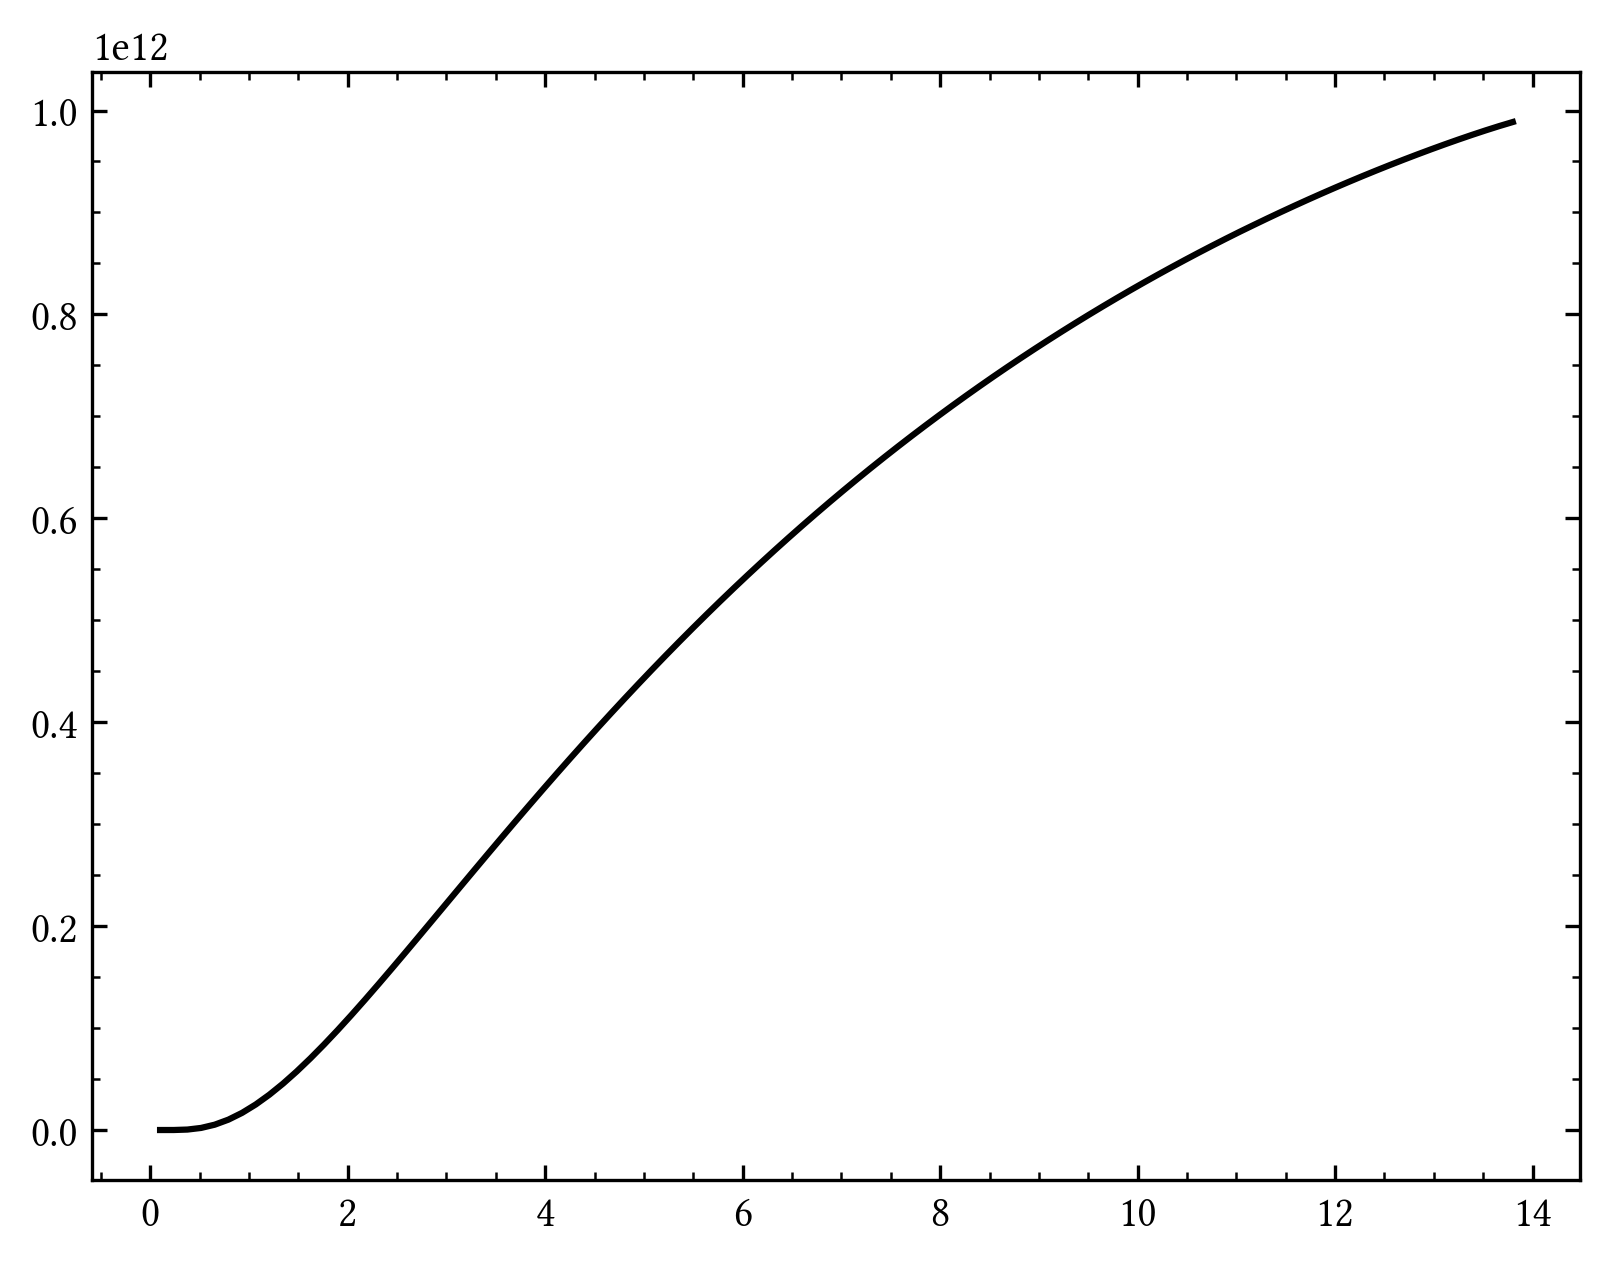

In [6]:
# Just a little test
t, M_dm, M_g, M_star, SFR = mass_evolution(12.0,data[12.0])

plt.plot(t,M_dm)

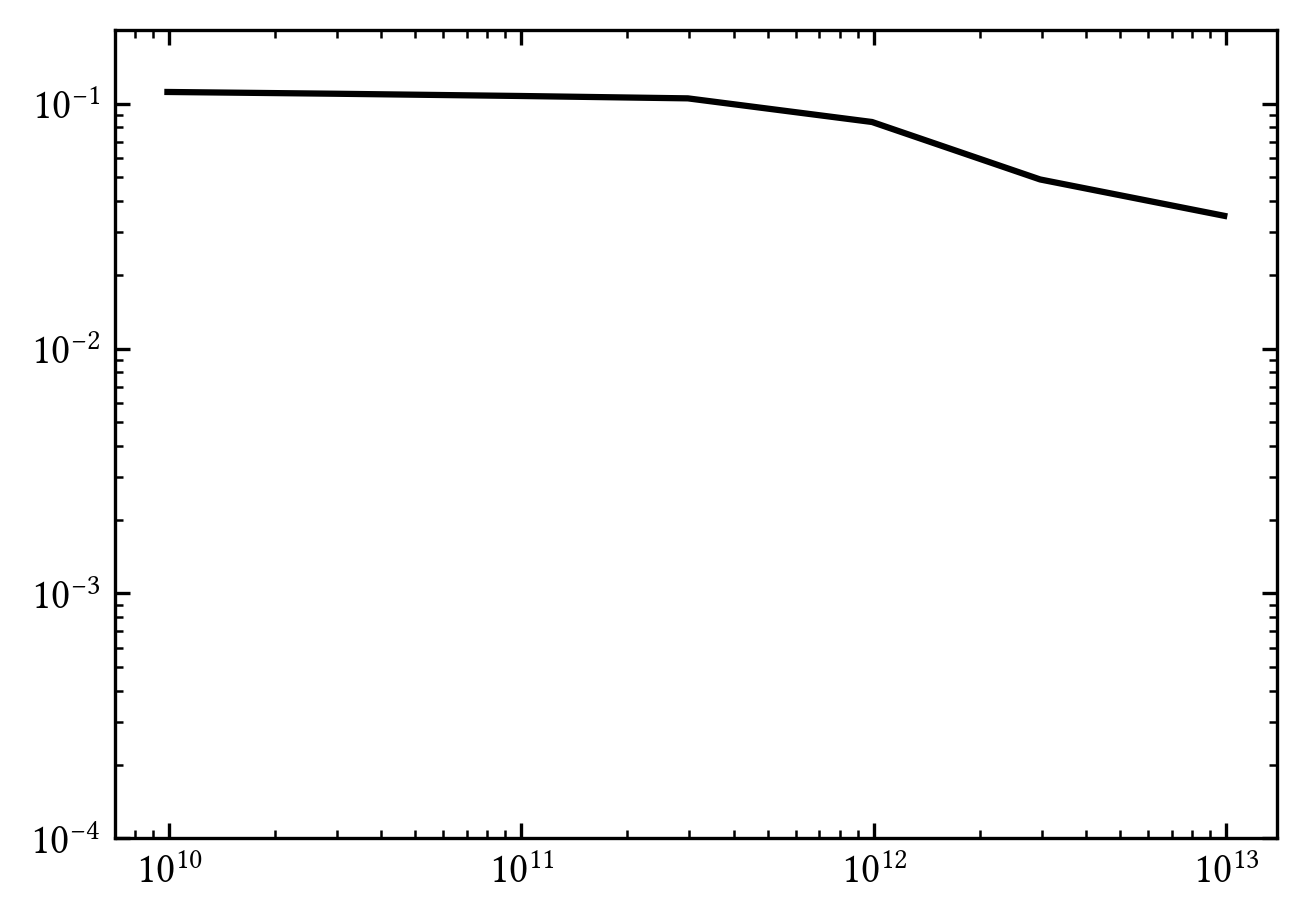

In [7]:

M_star_list = []
M_dm_list = []

for M_vir, df in data.items():
    _, M_dm, _, M_star, _ = mass_evolution(M_vir, df)
    M_star_list.append(M_star[-1])
    M_dm_list.append(M_dm[-1])

ratio = np.array(M_star_list)/np.array(M_dm_list)

fig, ax = plt.subplots(figsize = default_fsize)
ax.loglog(M_dm_list, ratio)
ax.set_ybound(1e-4,0.2)
plt.show()

## (vi) - ?

Now we are adding stellar feedback.

In [8]:
def mass_evolution_v2(M_vir, df, alpha=0.2, beta=0.2, f_b=0.18, stellar_frac=0.09, n_steps=100):
    ''' 
    Models the backwards evolution of the different masses

    INPUT
    -----
    M_vir : (float)
        Log_10 of the virial mass of the galaxy
    df : (pd.DataFrame)
        Dataframe with columns ['t_c','MAR']
    alpha, beta : (float)
        Parameters of the stellar feedback
    f_b : (float)
        Fraction of baryonic matter
    stellar_frac : (float)
        Fraction of stelar mass from total matter
    n_steps : (int)
        Number of time steps for the evolution

    OUTPUT
    -----
    t_reverse, M_dm, M_g, M_star, SFR : (np.ndarray)
        the results

    '''

    R = 0.4
    A = 2e-10
    M_crit = 6e11 # [Solar Masses]

    # Initialize
    t_cosmic = np.linspace(0.1,13.8,n_steps) # equidistant cosmic time in Gyr
    dt = 13.8 / n_steps * 1e9 # in yr

    dM_dm = np.interp(t_cosmic,df['t_c'][::-1],df['MAR'][::-1]) 

    M_dm, M_g, M_star, SFR, dM_g = np.zeros((5,n_steps))

    # Initial Values at t=t_0
    
    # M_dm[0], M_g[0], M_star[0] = get_initial_mass(M_vir, df, f_b, stellar_frac)
    SFR[0] = A * M_g[0]
    # dM_g[0] = gamma(M_dm[0]) * f_b * dM_dm[0] - (1 - R + beta * (M_dm[0]/M_crit)**(-alpha))*SFR[0]
    dM_g[0] = gamma(M_dm[0]) * f_b * dM_dm[0] - (1-R) * SFR[0] # ONLY for t=0, assuming here that gas outflow = 0 
    for i in range(n_steps-1):

        M_dm[i+1] = M_dm[i] + dM_dm[i] * dt
        M_star[i+1] = M_star[i] + (1-R) * SFR[i] * dt 
        M_g[i+1] = M_g[i] + dM_g[i] * dt
        if M_g[i+1] < 0: M_g[i+1] = 0 # Check for unrealistic results

        SFR[i+1] = A * M_g[i+1]
        dM_g[i+1] = gamma(M_dm[i+1]) * f_b * dM_dm[i+1] - (1 - R + beta * (M_dm[i+1]/M_crit)**(-alpha))*SFR[i+1]
    
    # return t_cosmic, M_dm, M_g, M_star, SFR
    return t_cosmic, M_dm, M_g, M_star, SFR

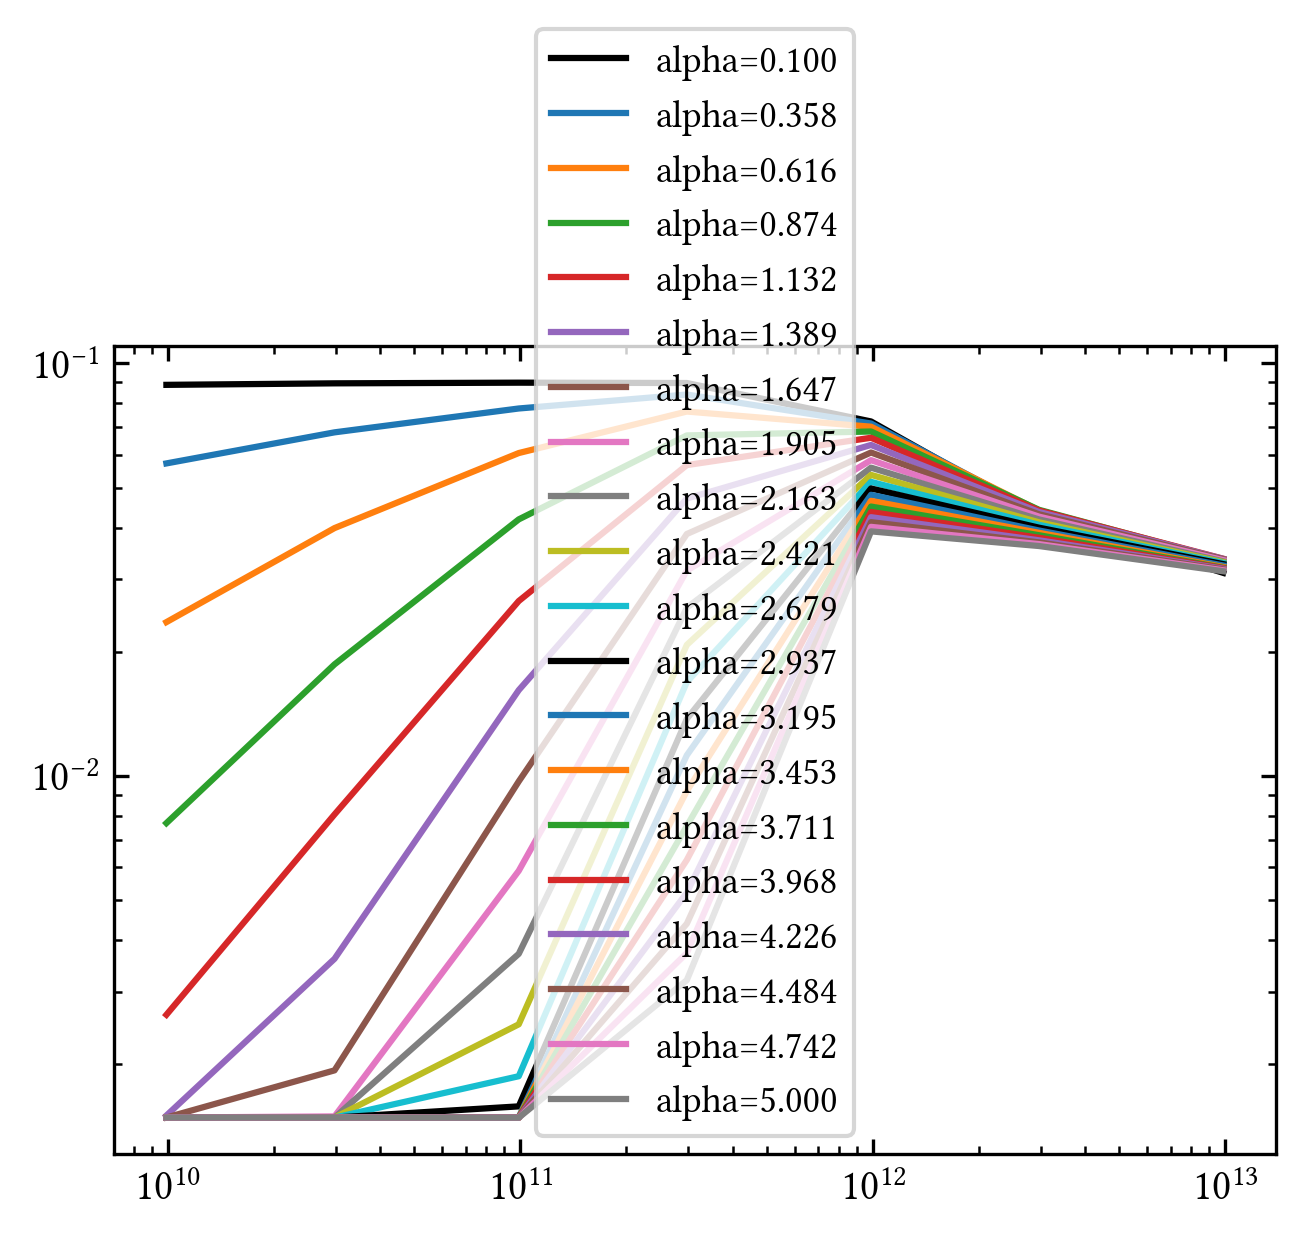

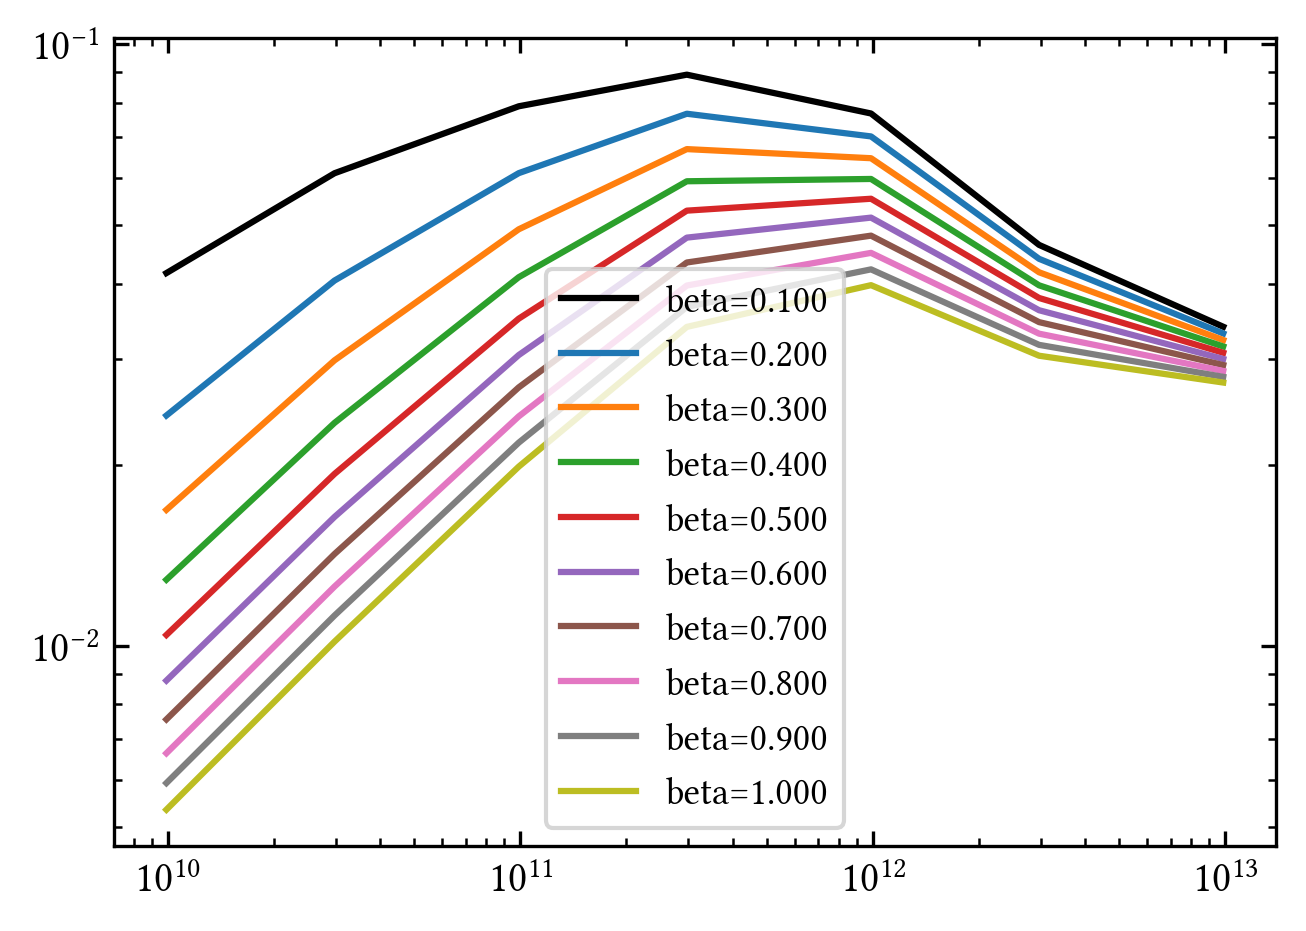

In [9]:
alpha_space = np.linspace(0.1,5,20)

fig,ax = plt.subplots(figsize = default_fsize)

for alpha in alpha_space:
    M_star_list = []
    M_dm_list = []

    for M_vir, df in data.items():
        _, M_dm, _, M_star, _ = mass_evolution_v2(M_vir, df, alpha=alpha)
        M_star_list.append(M_star[-1])
        M_dm_list.append(M_dm[-1])

    ratio = np.array(M_star_list)/np.array(M_dm_list)
    if ratio[0] <= 1: ax.loglog(M_dm_list, ratio, label=f"alpha={alpha:.3f}")
ax.legend()
plt.show()
plt.close()

alpha_best = 0.61

beta_space = np.linspace(0.1,1,10)
fig,ax = plt.subplots(figsize = default_fsize)

for beta in beta_space:
    M_star_list = []
    M_dm_list = []

    for M_vir, df in data.items():
        _, M_dm, _, M_star, _ = mass_evolution_v2(M_vir, df, alpha=alpha_best, beta=beta)
        M_star_list.append(M_star[-1])
        M_dm_list.append(M_dm[-1])

    ratio = np.array(M_star_list)/np.array(M_dm_list)
    if ratio[0] <= 1: ax.loglog(M_dm_list, ratio, label=f"beta={beta:.3f}")
ax.legend()
plt.show()
plt.close()


        

To Do
- Make Plots pretty
- Look at virial mass to dm ratio

# Appendix

Code that was written but not used, just in case we need to recycle it.

1. `get_initial_mass()` function to get the initial values for M_dm, M_g, M_star. However, it turns out to get better restults by starting with 0,0,0

In [10]:
def get_initial_mass(M_vir, df, f_b=0.18, stellar_frac=0.09):
    '''
    Gets the initials masses at t_c = 0 for dm, gas and stars

    INPUT
    -----
    M_vir : (float)
    df    : (pd.DataFrame)
    dm_ratio, stellar_ratio : (float)

    OUTPUT
    -----
    M_dm, M_g, M_star : (float)
    '''

    dm_frac = 1.0 - f_b
    dm_frac = 1    # Assuming M_dm = M_vir for z = 0 offers good results (something is wrong)
    
    # Extract the data
    t_c   = df['t_c']
    dM_dm = df['MAR']
    M0_dm = dm_frac * 10**M_vir              # Dark matter mass at z=0

    area = 0                                 # This will be our integral
    # print(f"At z=0: M_dm = {M0_dm:.3f}")

    for i in range(len(t_c) - 1):
        area += (t_c[i+1] - t_c[i]) * 1e9 * dM_dm[i]   # delta t [Gyr] * 1e9 * delta M [solar masses/yr]
    # print(f'Area: {area:.3}')

    M_dm = M0_dm + area                      # Dark matter mass t_c=0. Area is negative since we are going backwards in time
    # print(f"At t=0: M_dm = {M_dm:.3}")
    
    # Calculating stellar mass and gas mass from ratio to dm
    dm_frac   = 1.0 - f_b
    gas_ratio = 1 - dm_frac - stellar_frac 
    M_star    = M_dm * stellar_frac/dm_frac  # Stellar mass
    M_g       = M_dm * gas_ratio/dm_frac     # Gas mass t=0

    return M_dm, M_g, M_star

print(get_initial_mass(10,data[10]))


(np.float64(86655018.8999958), np.float64(9510916.708536118), np.float64(9510916.708536124))
